# Import Library

In [1]:
# Import External Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob

import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.metrics import MeanSquaredError

from scipy import stats
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

D:\Downloads\anaconda\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Read CSV Data

In [2]:
# Read Data Train
df_train = pd.read_csv(r'D:\Downloads\FDR Landing - Excel\train_set.csv')
df_val = pd.read_csv(r'D:\Downloads\FDR Landing - Excel\val_set.csv')
df_test = pd.read_csv(r'D:\Downloads\FDR Landing - Excel\test_set.csv')

In [3]:
features_col = ['aoac_rad','theta_rad', 'ax_body_mps2']
targets_col = ['elv_l_deg']

In [4]:
df_train[targets_col].describe()

,elv_l_deg
count,35687.000000
mean,-24.291740
std,1.596665
min,-28.459127
25%,-25.290671
50%,-24.305183
75%,-23.325426
max,-20.048107


In [5]:
df_val[targets_col].describe()

,elv_l_deg
count,4346.000000
mean,-23.759169
std,1.418572
min,-27.926277
25%,-24.734902
50%,-23.692119
75%,-22.832682
max,-19.601200


In [6]:
df_test[targets_col].describe()

,elv_l_deg
count,4911.000000
mean,-23.899519
std,1.462055
min,-27.846063
25%,-24.838034
50%,-24.041623
75%,-22.975921
max,-19.767358


##### Plot each features used, to see each feature value range

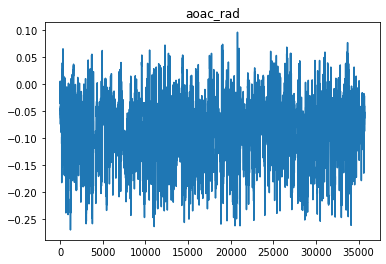

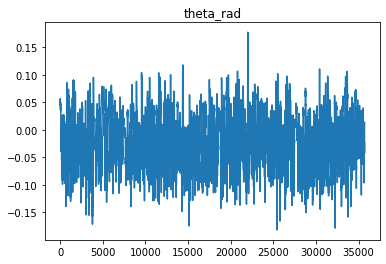

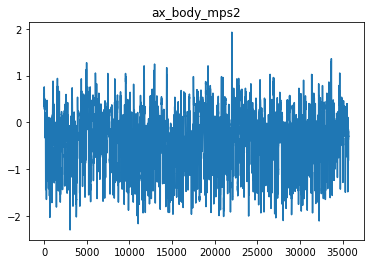

In [7]:
for col_name in features_col:
    plt.plot(df_train[col_name])
    plt.title(col_name)
    plt.show()

Text(0.5, 1.0, "['elv_l_deg']")

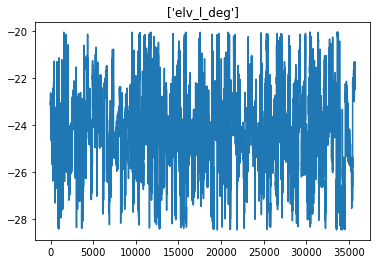

In [8]:
plt.plot(df_train[targets_col])
plt.title(targets_col)

# Create Feature & Target Data

##### Features and targets data type will be converted first as 'float32' and then by using MinMaxScaler, we normalize only the features to have value between 0 and 1

In [35]:
X_train = df_train[features_col].values.astype('float32')
X_val = df_val[features_col].values.astype('float32')

scaler = MinMaxScaler(feature_range=(-1, 1))
transformer = scaler.fit(X_train)
X_train = transformer.transform(X_train)
X_val = transformer.transform(X_val)


y_train = df_train[targets_col].values.astype('float32')
y_val = df_val[targets_col].values.astype('float32')

## Hyperparamater Tuning using Keras Tuner

* First, we need to define the based model function that can be seen in 'call_existing_ANN' function
* The based model consist of hyperparameter variable that will be tuned.
* We will use basic dense model, with loss function = MSE and metrics = MAE

## Define model function

In [36]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,Bidirectional,LSTM,Bidirectional, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import TensorBoard
from keras.constraints import maxnorm


hp = kt.HyperParameters()

def call_existing_ANN(units1, units_hidden, activation,initializer, activation_hidden, optimizer, dropout,do_rate, lr, num_hidden, x_train, y_train):
    model = Sequential()                            
    model.add(Dense(units=units1,
                    input_dim=(x_train.shape[1]),
                    kernel_initializer=initializer))
    
    # Add Hidden layers
    for i in range(num_hidden):
        model.add(Dense(units=units_hidden,
                       activation=activation_hidden))

    # Add dropout layers
    if dropout:
        model.add(Dropout(rate=do_rate))
        
    model.add(Dense(y_train.shape[1],
                    activation=activation))
    
    # Compiling Model
    model.compile(optimizer=optimizer,
                  loss="mean_squared_error",
                  metrics=["mean_absolute_error"])
    
    return model

* In the 'build_model' function below, we define hyperparameter space of the variable we mention earlier
* Then, we call the 'call_existing_ANN' function and filll the parameter with the space variable

In [37]:
def build_model(hp):
    units1 = hp.Int("units1", min_value=8, max_value=32, step=4)
    units_hidden = hp.Int("units_hidden", min_value=8, max_value=32, step=4)
    initializer = hp.Choice("initalizer", ['zeros','glorot_normal','he_normal'])
    num_hidden = hp.Choice('num_hidden', [0,1])
    activation_hidden = hp.Choice("activation_hidden", ['elu','LeakyReLU'])
    activation = hp.Choice("activation", ['elu','LeakyReLU'])
    optimizer = hp.Choice("optimizer", ['sgd', 'rmsprop', 'adam'])
    dropout = hp.Boolean("dropout")
    dropout_rate = hp.Float("rate", min_value=0.1, max_value=0.4, step=0.1)
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")
    
    # Learning rate for optimizer 
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate = lr)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate = lr)
    elif optimizer == 'adam':
        optimizer = Adam(learning_rate = lr)
    
    # Dropout rate
    if dropout == True:
        do_rate = dropout_rate
    
    # call existing model-building code with the hyperparameter values.
    model = call_existing_ANN(units1=units1, units_hidden=units_hidden,
                               activation=activation, dropout=dropout,do_rate=dropout_rate,
                              activation_hidden = activation_hidden,
                              initializer=initializer,
                               lr=lr, optimizer=optimizer,
                               num_hidden = num_hidden,
                               x_train=X_train, y_train=y_train)
    return model

In [38]:
build_model(kt.HyperParameters())

In [39]:
project_name = input('Project name:')

Project name:elevator_13oct_v3


* Now, we define the method of KerasTuner library that we want to use. In this case we choose Bayesian Optimization. 
* We can specify the function we create as the hypermodel, objective that we want (loss or val loss), and how many trials the iteration process will be, also each set of hyperparameter executions in this case 1 set will be execute 1 time.\
* In this process, we use 50 trials to get best hyperparameter set, eventhough number of combinations of the hyperparameter that can be tried is very big. But to shorten computation time and find the local minimum value, we think 50 trials is enough 

In [42]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="loss",
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
    project_name=project_name)

* We use tuner.search by specifying features and targets, how many epochs it will be trained, and validation variable data we use
* We choose 5 for the epochs value, because we don't want to use 1 epochs because it will be very variative loss in the first epochs, and we choose 5 because to shorthen computation time while seeing more converge value than 1 epochs do.

In [43]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val), verbose=1)

Trial 50 Complete [00h 00m 33s]
loss: 1.9874000549316406

Best loss So Far: 1.824587106704712
Total elapsed time: 00h 29m 28s
INFO:tensorflow:Oracle triggered exit


In [44]:
tuner.results_summary()

Results summary
Results in my_dir\elevator_13oct_v3
Showing 10 best trials
Trial summary
Hyperparameters:
units1: 32
units_hidden: 24
initalizer: zeros
num_hidden: 1
activation_hidden: LeakyReLU
activation: LeakyReLU
optimizer: sgd
dropout: False
rate: 0.30000000000000004
lr: 0.0001
Score: 1.824587106704712
Trial summary
Hyperparameters:
units1: 32
units_hidden: 16
initalizer: zeros
num_hidden: 1
activation_hidden: LeakyReLU
activation: LeakyReLU
optimizer: sgd
dropout: False
rate: 0.4
lr: 0.0001
Score: 1.8259942531585693
Trial summary
Hyperparameters:
units1: 32
units_hidden: 32
initalizer: zeros
num_hidden: 1
activation_hidden: LeakyReLU
activation: LeakyReLU
optimizer: sgd
dropout: False
rate: 0.1
lr: 0.0001
Score: 1.8345569372177124
Trial summary
Hyperparameters:
units1: 32
units_hidden: 8
initalizer: zeros
num_hidden: 1
activation_hidden: LeakyReLU
activation: LeakyReLU
optimizer: sgd
dropout: False
rate: 0.2
lr: 0.0001
Score: 1.8362561464309692
Trial summary
Hyperparameters:
unit

##### Next, we will train our dataset using best hyperparameter from Bayesian Optimization result

* We use early stopping when loss variable value is stucked, so we can iterate until 200 epochs

In [45]:
best_hps = tuner.get_best_hyperparameters(1)[0]
model = build_model(best_hps)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), batch_size = 32, callbacks=[stop_early])

Epoch 1/200
1116/1116 [==============================] - 5s 4ms/step - loss: 378.9618 - mean_absolute_error: 17.4493 - val_loss: 1.8655 - val_mean_absolute_error: 1.0740
Epoch 2/200
1116/1116 [==============================] - 5s 4ms/step - loss: 2.0061 - mean_absolute_error: 1.1227 - val_loss: 1.9780 - val_mean_absolute_error: 1.1003
Epoch 3/200
1116/1116 [==============================] - 5s 4ms/step - loss: 1.9297 - mean_absolute_error: 1.0970 - val_loss: 1.9174 - val_mean_absolute_error: 1.0874
Epoch 4/200
1116/1116 [==============================] - 5s 4ms/step - loss: 1.8749 - mean_absolute_error: 1.0788 - val_loss: 1.8507 - val_mean_absolute_error: 1.0701
Epoch 5/200
1116/1116 [==============================] - 5s 4ms/step - loss: 1.8338 - mean_absolute_error: 1.0655 - val_loss: 1.8921 - val_mean_absolute_error: 1.0911
Epoch 6/200
1116/1116 [==============================] - 4s 4ms/step - loss: 1.8023 - mean_absolute_error: 1.0549 - val_loss: 1.8621 - val_mean_absolute_error: 1.

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                128       
                                                                 
 dense_4 (Dense)             (None, 24)                792       
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 945
Trainable params: 945
Non-trainable params: 0
_________________________________________________________________


##### From the best hyperparameter model that have been trained, we will see the prediction result from this model on the validation set and compare it to targeted value

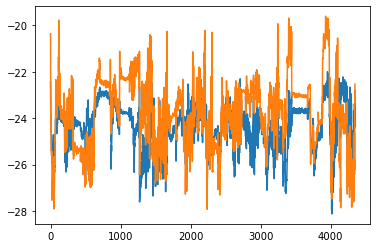

In [48]:
plt.plot(model.predict(X_val))
plt.plot(y_val)

##### It can be seen that 4 graphs from predicted value and 4 graph from the real data show the same pattern and range of value. 

## Plot MSE & MAE vs epochs

<AxesSubplot:title={'center':'Loss'}>

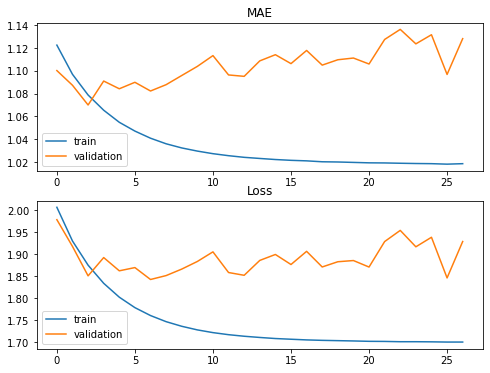

In [49]:
fig,axs = plt.subplots(2,figsize=(8,6))

loss_train = history.history['loss']
loss_val = history.history['val_loss']

metrics_train = history.history['mean_absolute_error']
metrics_val = history.history['val_mean_absolute_error']

pd.Series(metrics_train[1:]).rename('train').plot(legend=True,title='MAE',ax=axs[0])
pd.Series(metrics_val[1:]).rename('validation').plot(legend=True,ax=axs[0])

pd.Series(loss_train[1:]).rename('train').plot(legend=True,title='Loss',ax=axs[1])
pd.Series(loss_val[1:]).rename('validation').plot(legend=True,ax=axs[1])

* From graph above, we can see the training process converge really well to certain value. Where the validation set MSE and MAE graph is fluctuating and tend to have higher value.

* It shows that our model doesn't encounter overfitting, but maybe it will not be well predicted on the validation set. But we will see the behavior of our model when compare the target of each flight in test dataset.

* Hence, we can save the model as *.h5 file

# Save Model

In [21]:
model.save("elevator_13oct_v1.h5")

## Load saved h5 model

In [9]:
h5_file_name_load = 'elevator_13oct_v1.h5'

In [10]:
# Load Model from h5 file
model = keras.models.load_model(h5_file_name_load)

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 32        
                                                                 
 dense_5 (Dense)             (None, 28)                252       
                                                                 
 dense_6 (Dense)             (None, 28)                812       
                                                                 
 dense_7 (Dense)             (None, 1)                 29        
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


##### The last step is to use our model to predict each landing phase file and see wether the trend of power lever angle deflection of predicted value is similar enough to the real value

# Test On Test Set

File Name: Landing_100.csv


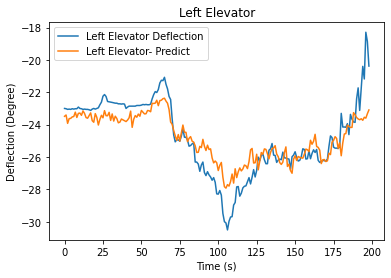

File Name: Landing_105.csv


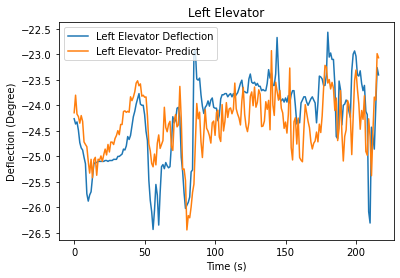

File Name: Landing_110.csv


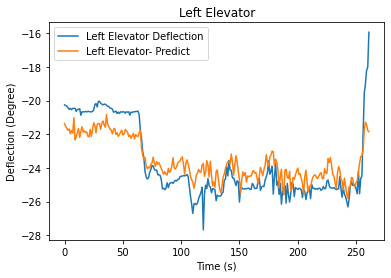

File Name: Landing_126.csv


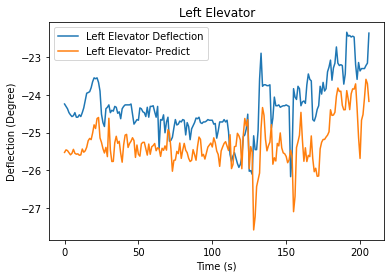

File Name: Landing_13.csv


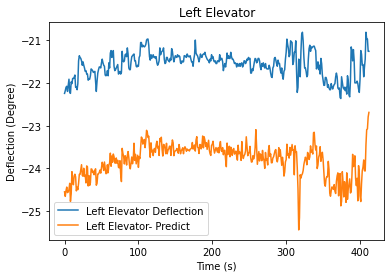

File Name: Landing_135.csv


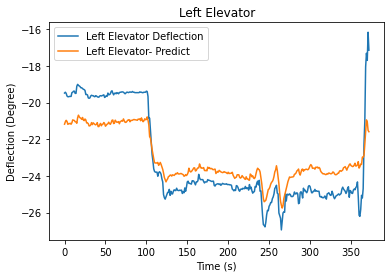

File Name: Landing_145.csv


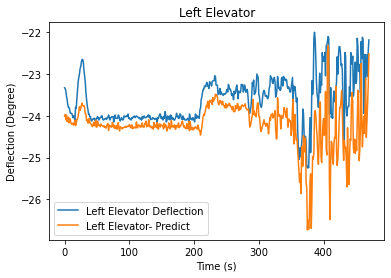

File Name: Landing_147.csv


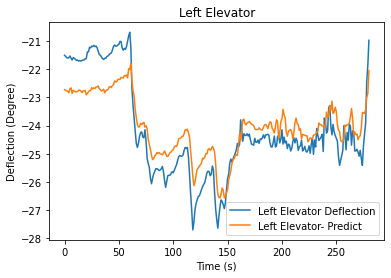

File Name: Landing_152.csv


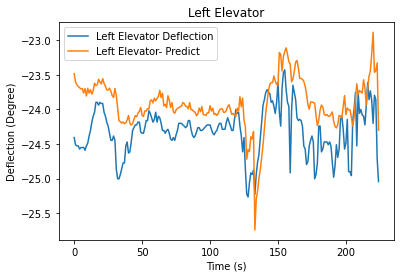

File Name: Landing_156.csv


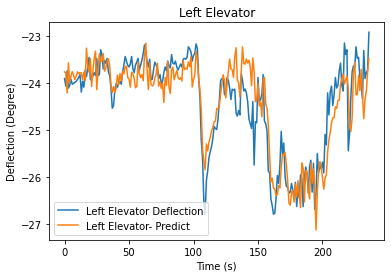

File Name: Landing_162.csv


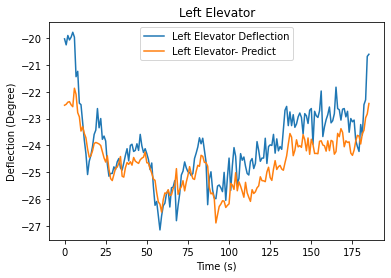

File Name: Landing_167.csv


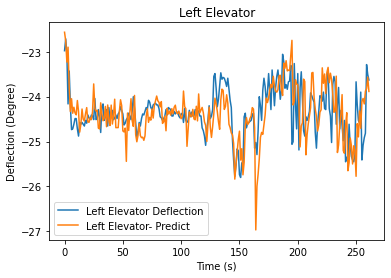

File Name: Landing_174.csv


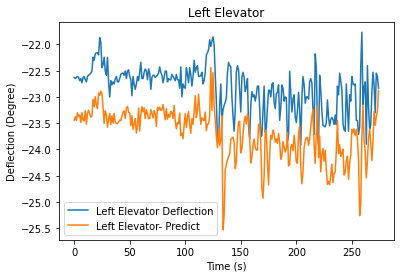

File Name: Landing_194.csv


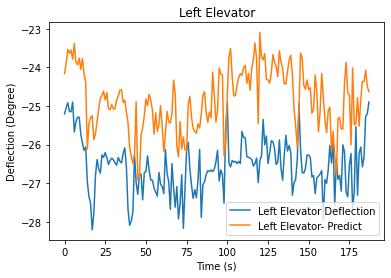

File Name: Landing_26.csv


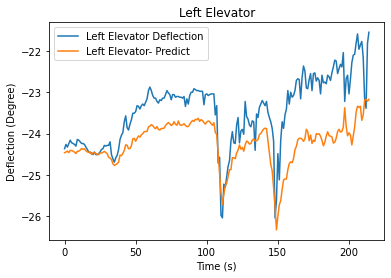

File Name: Landing_32.csv


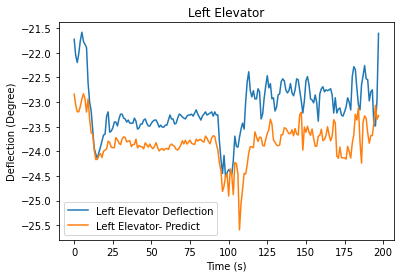

File Name: Landing_77.csv


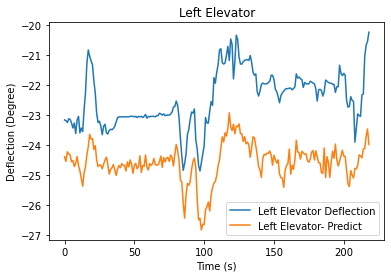

File Name: Landing_84.csv


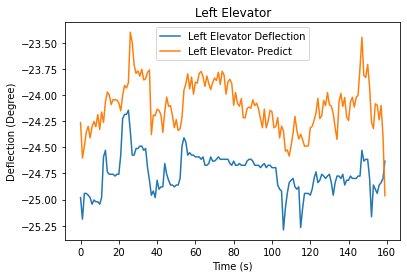

File Name: Landing_90.csv


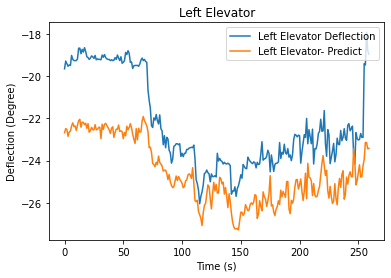

File Name: Landing_98.csv


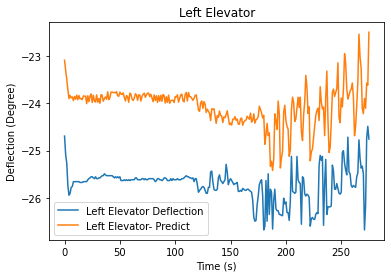

In [50]:
# Import Library
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from numpy import isnan, arange, rad2deg


# loop over the list of csv files

csv_files =  [i for i in glob.glob('D:\Downloads\FDR Landing - Excel\Test Set\*.csv')]

for f in csv_files:

    df_test = pd.read_csv(f)
    
    # Create  X_test and y_test variable using df_to_array function
    X_test = df_test[features_col].values.astype('float32')
    X_test = transformer.transform(X_test)
    y_test = df_test[targets_col].values.astype('float32')

    # Predict X_test using model that have been created
    elv_predicted = model.predict(X_test)

    # Print each file name
    print('File Name:', f.split("\\")[-1])

    plt.plot(df_test[targets_col], label='Left Elevator Deflection')
    plt.plot(elv_predicted, label='Left Elevator- Predict')
    plt.title("Left Elevator")
    plt.xlabel('Time (s)')
    plt.ylabel('Deflection (Degree)')
    plt.legend(loc='best')

    plt.show()


##### It can be seen that our model can follow the actual elevator trend really well. But sometimes, it can be seen some of the test file have an offset starting value from the actual deflection but not greater than 2 degree, rather than that, the model can imitate how pilot control the elevator by using control column. 

##### Hence, we can say that our model is succes to modeling elevator deflection in landing phase.